In [17]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense


In [19]:
# 설정
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [20]:
%pwd
%cd ..

/Users/mi-yeonlim/Documents/Github/translate-handsign


In [21]:

#  데이터 로드
actions = [
    "답답하다", "땀난다", "베였다", "부었다", "불편하다",
    "아프다", "어지럽다", "열난다", "지속된다", "피곤하다"
]
time_nums = ['1744797254', '1744797393', '1744797530']
base_path = 'dataset'
all_data = []



In [22]:
for time_num in time_nums:
    for action in actions:
        file_path = f'{base_path}/seq_{action}_{time_num}.npy'
        if os.path.exists(file_path):
            data = np.load(file_path)
            all_data.append(data)
        else:
            print(f"❌ 존재하지 않음: {file_path}")

if not all_data:
    raise ValueError("❌ 유효한 데이터가 없습니다. npy 파일을 먼저 생성하세요.")


In [23]:
# 데이터 결합
if not all_data:
    raise ValueError("❌ 유효한 데이터가 없습니다. npy 파일을 먼저 생성하세요.")
data = np.concatenate(all_data, axis=0)
print("✅ 전체 데이터 shape:", data.shape)

✅ 전체 데이터 shape: (1353, 10, 56)


In [24]:
#  Feature(X), Label(y) 분리
x_data = data[:, :, :-1]     # 시퀀스의 피처 (마지막 컬럼 제외)
labels = data[:, 0, -1]      # 라벨은 첫 프레임의 마지막 값

In [25]:
# 라벨 인코딩
lb = LabelBinarizer()
labels_encoded = lb.fit_transform(labels)

In [26]:

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    x_data,
    labels_encoded,
    test_size=0.2,
    random_state=42,
    stratify=labels
)
print('훈련 샘플 수:', len(X_train))
print('테스트 샘플 수:', len(X_test))
print("훈련 입력 shape:", X_train.shape)

훈련 샘플 수: 1082
테스트 샘플 수: 271
훈련 입력 shape: (1082, 10, 55)


In [27]:
# 모델 구성 (입력 피처 수 = 55)
model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(10, 55)),
    Dropout(0.3),
    LSTM(64, return_sequences=False, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(actions), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/opt/anaconda3/envs/hi/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# 모델 학습
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.2150 - loss: 21.7165 - val_accuracy: 0.7122 - val_loss: 4.5131
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.5902 - loss: 3.9184 - val_accuracy: 0.8487 - val_loss: 1.4747
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.7227 - loss: 2.1337 - val_accuracy: 0.9299 - val_loss: 0.2922
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.8307 - loss: 2.2125 - val_accuracy: 0.8967 - val_loss: 3.1607
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.7402 - loss: 3.4332 - val_accuracy: 0.8487 - val_loss: 1.8288
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.6414 - loss: 6.7106 - val_accuracy: 0.8229 - val_loss: 1.2774
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.6851 - loss: 4.1331 - val_accuracy: 0.8303 - val_loss: 1.4870
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.8073 - loss: 1.1591 - val_accuracy: 

In [29]:
# 예측 결과 확인

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [30]:
# 모델 평가 
loss, accuracy = model.evaluate(X_test, y_test)
print(f" 테스트 손실(Loss): {loss:.4f}")
print(f"테스트 정확도(Accuracy): {accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9973 - loss: 0.0242
 테스트 손실(Loss): 0.0305
테스트 정확도(Accuracy): 0.9963


	•	precision: 얼마나 정확히 예측했는가 (false positive 줄이기)
	•	recall: 얼마나 놓치지 않고 잘 잡았는가 (false negative 줄이기)
	•	f1-score: precision과 recall의 조화 평균

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_true_labels, y_pred_labels, target_names=actions))

              precision    recall  f1-score   support

        답답하다       1.00      1.00      1.00        22
         땀난다       1.00      1.00      1.00        16
         베였다       1.00      1.00      1.00        23
         부었다       1.00      0.95      0.98        21
        불편하다       1.00      1.00      1.00        25
         아프다       1.00      1.00      1.00        23
        어지럽다       1.00      1.00      1.00        56
         열난다       1.00      1.00      1.00        34
        지속된다       1.00      1.00      1.00        22
        피곤하다       0.97      1.00      0.98        29

    accuracy                           1.00       271
   macro avg       1.00      1.00      1.00       271
weighted avg       1.00      1.00      1.00       271



In [32]:
# 혼돌 행렬 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 예측 결과 생성
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)




9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')


<Figure size 1000x800 with 0 Axes>

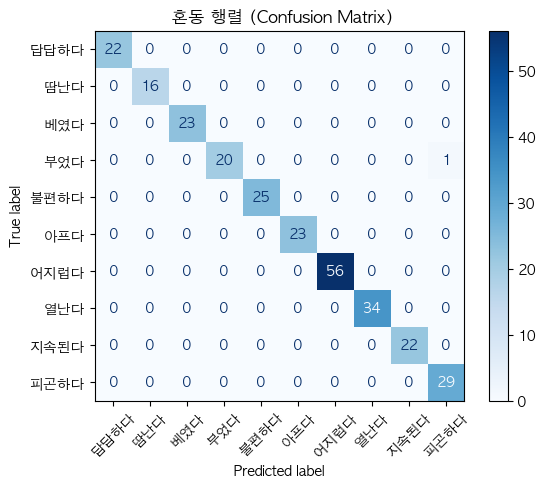

In [34]:
# 혼동 행렬 계산
cm = confusion_matrix(y_true_labels, y_pred_labels)

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actions)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title(" 혼동 행렬 (Confusion Matrix)")
plt.show()

🔵 파란색은 맞춘 비율이 높은 부분이고, 색이 연할수록 틀린 경우입니다.

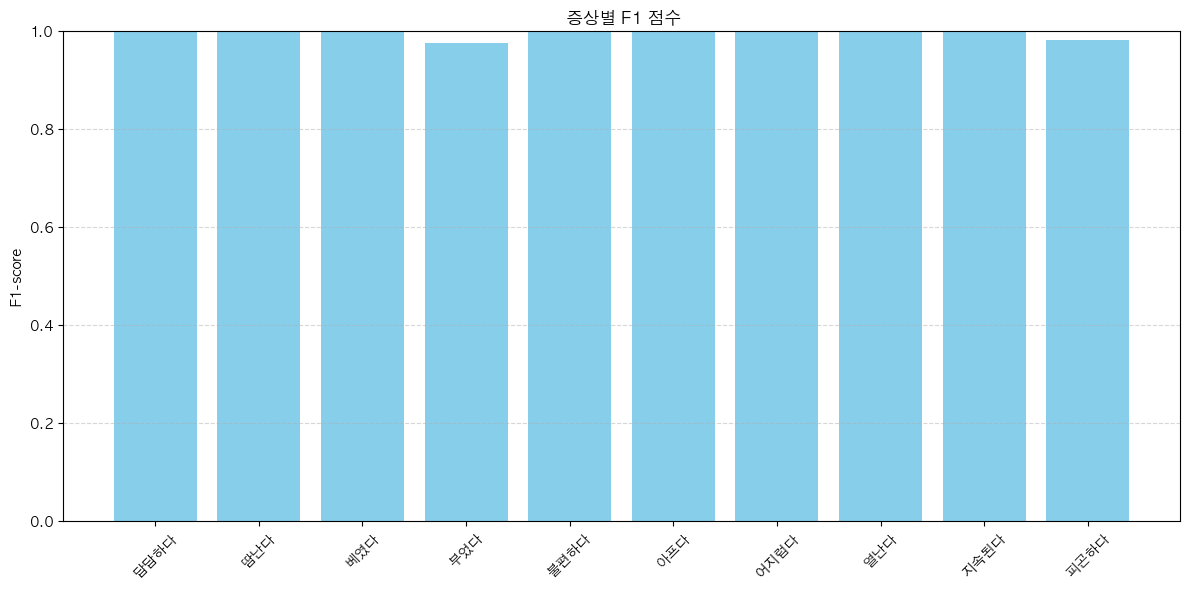

In [35]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

report = classification_report(y_true_labels, y_pred_labels, target_names=actions, output_dict=True)
accuracy_per_class = [report[label]['f1-score'] for label in actions]

plt.figure(figsize=(12, 6))
plt.bar(actions, accuracy_per_class, color='skyblue')
plt.ylabel("F1-score")
plt.title(" 증상별 F1 점수")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [36]:
#  모델 저장
os.makedirs("models", exist_ok=True)
model.save("models/multi_face_expression_classifier.h5")
print(" 얼굴 표정 기반 증상 분류 모델 저장 완료")

 얼굴 표정 기반 증상 분류 모델 저장 완료


In [6]:
%pwd
%cd ..

/Users/mi-yeonlim/Documents/Github/translate-handsign


In [7]:
import tensorflow as tf

# 변환 대상 모델 경로 (.h5)
keras_model_path = "models/multi_face_expression_classifier.h5"

In [9]:
import os

if not os.path.exists(keras_model_path):
    raise FileNotFoundError(f"❌ Keras 모델이 존재하지 않습니다: {keras_model_path}")
else:
    print("✅ 모델이 정상적으로 존재합니다.")

✅ 모델이 정상적으로 존재합니다.


In [10]:
# 모델 로드
model = tf.keras.models.load_model(keras_model_path)
print("✅ Keras 모델 로드 완료")

✅ Keras 모델 로드 완료


In [11]:
# TFLite 변환기 생성
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # 선택: 양자화 가능

In [ ]:
# 고급 연산 및 버전 호환 옵션
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS  # 고급 연산 포함
]
converter.experimental_enable_resource_variables = True
converter._experimental_lower_tensor_list_ops = False

In [ ]:
# 변환 수행
tflite_model = converter.convert()
print("✅ TFLite 모델 변환 완료")

In [ ]:
# 저장할 TFLite 모델 경로
tflite_model_path = "content/multi_face_expression_classifier.tflite"
print("✅ .tflite 모델 저장 완료")